In [1]:
import edlib
import numpy as np
import heapq
import time
from Bio.Seq import Seq
import copy
import matplotlib.pyplot as plt
def rc(seq):
    return str(Seq(seq).reverse_complement())
def calculate_distance(ref, query, ref_st, ref_en, query_st, query_en):
    A = ref[ref_st: ref_en]
    a = query[query_st: query_en]
    # _a = rc(query[query_st: query_en])
    # return min(edlib.align(A, a)['editDistance'], edlib.align(A, _a)['editDistance'])
    return edlib.align(A, a)['editDistance']

def calculate_value(points, ref, query,penalty):  
    try:
        editdistance = 0
        aligned = 0
        preend = 0
        for onetuple in points:
            query_st, query_en, ref_st, ref_en = onetuple[0], onetuple[1], onetuple[2], onetuple[3]
            if(preend > query_st):#检测重叠
                return 0
            preend = query_en
            editdistance += calculate_distance(ref, query, ref_st, ref_en, query_st, query_en)
            aligned += query_en - query_st
        return aligned - editdistance - len(points) * penalty #额外的惩罚碎片化的输出
    except:
        return 0

In [2]:
def simulated_annealing(origin,update,scoring,t0,kt=0.97,round=20,printf=False):
    score=scoring(origin)
    data=origin

    final=data
    final_score=score
    while(t0>=1):
        for i in range(round):
            nxt_data=update(data,t0)
            nxt_score=scoring(nxt_data)

            delta=nxt_score-score
            if(np.exp(delta/t0)>np.random.rand()):
                data=nxt_data
                score=nxt_score
                if(printf):print(data,score)
                if(score>final_score):
                    final,final_score=data,score
        data=final
        score=final_score
        t0*=kt
        if(printf):print(t0)
    return final,final_score

In [3]:
class PhaseMatch:
    def __init__(self,l,r,ml):
        self.l=l
        self.r=r
        self.scorelist=ml

def printPhaseMatch(l,topk):
    for i in l:
        for j in range(len(i.scorelist)):
            color=1/topk*j
            if(i.scorelist[j][1]>i.scorelist[j][2]):color=(0,0,1-color)
            else:color=(1-color,0,0)
            plt.plot((i.l,i.r),(i.scorelist[j][1],i.scorelist[j][2]),color=color)
    plt.show()

In [4]:
import tqdm
def DNA_match(reference,sample,seglen,penalty,topk):
    match_list=[]
    pbar=tqdm.tqdm(total=len(sample))
    for i in range(0,len(sample),seglen):
        ri=min(i+seglen,len(sample))
        scorelist=[]
        for j in range(0,len(reference),seglen):
            rj=min(j+seglen,len(reference))
            scorelist.append((ri-i-edlib.align(reference[j:rj],sample[i:ri])['editDistance'],j,rj))
        scorelist=heapq.nlargest(topk,scorelist)

        for j in range(len(scorelist)):

            origin=[[i,ri,scorelist[j][1],scorelist[j][2]]]
            def update(data,t0):
                dv=max(int(t0),5)
                newdata=copy.deepcopy(data)
                newdata[0][2]+=np.random.randint(-dv,dv)
                newdata[0][2]=np.clip(newdata[0][2],0,len(reference))
                newdata[0][3]+=np.random.randint(-dv,dv)
                newdata[0][3]=np.clip(newdata[0][3],0,len(reference))
                return newdata
            def scoring(data):
                return calculate_value(data,reference,sample,penalty)
            data,score=simulated_annealing(origin,update,scoring,3,0.97,5)
            scorelist[j]=(score,data[0][2],data[0][3])
        
        scorelist=heapq.nlargest(topk,scorelist)
        if(len(scorelist)>0):
            match_list.append((PhaseMatch(i,ri,scorelist),1))
        pbar.update(seglen)
    pbar.close()

    while True:
        mergel=0
        new_match_list=[]
        with tqdm.tqdm(total=len(match_list)) as pbar:
            while(mergel<len(match_list)):
                if(mergel==len(match_list)-1):
                    new_match_list.append((match_list[mergel][0],0))
                    break
                if match_list[mergel][1]==0 and match_list[mergel+1][1]==0:
                    new_match_list.append((match_list[mergel][0],0))
                    mergel+=1
                    pbar.update(1)
                    continue
                l=match_list[mergel][0].l
                r=match_list[mergel+1][0].r
                lenl=match_list[mergel][0].r-match_list[mergel][0].l
                lenr=match_list[mergel+1][0].r-match_list[mergel+1][0].l
                scorelist=[]
                scorebound=match_list[mergel][0].scorelist[0][0]+match_list[mergel+1][0].scorelist[0][0]
                def merge(refl,refr):
                    origin=[[l,r,refl,refr]]
                    def update(data,t0):
                        dv=max(int(t0),10)
                        newdata=copy.deepcopy(data)
                        newdata[0][2]+=np.random.randint(-dv,dv)
                        newdata[0][2]=np.clip(newdata[0][2],0,len(reference))
                        newdata[0][3]+=np.random.randint(-dv,dv)
                        newdata[0][3]=np.clip(newdata[0][3],0,len(reference))
                        return newdata
                    def scoring(data):
                        return calculate_value(data,reference,sample,penalty)
                    data,score=simulated_annealing(origin,update,scoring,max((r-l)//10,5),0.96,10)
                    if(score>scorebound):
                        def IoU(l1,r1,l2,r2):
                            d1=max(r1-l1,0)
                            d2=max(r2-l2,0)
                            d3=max(min(r1,r2)-max(l1,l2),0)
                            if(d3>(d1+d2-d3)*0.9):return False
                            else:return True
                        flag=True
                        for i in scorelist:
                            if not IoU(i[1],i[2],data[0][2],data[0][3]):
                                flag=False
                                break
                        if flag:
                            scorelist.append((score,data[0][2],data[0][3]))
                    
                for j in match_list[mergel][0].scorelist:
                    merge(j[1],min(j[2]+lenr,len(reference)))
                for j in match_list[mergel+1][0].scorelist:
                    merge(max(j[1]-lenl,0),j[2])
                if(len(scorelist)>0):
                    scorelist=heapq.nlargest(topk,scorelist)
                    new_match_list.append((PhaseMatch(l,r,scorelist),1))
                    pbar.update(2)
                    mergel+=2
                else:
                    new_match_list.append((match_list[mergel][0],0))
                    pbar.update(1)
                    mergel+=1
        if(len(new_match_list)<len(match_list)):
            match_list=new_match_list
            print("segment count: ",len(match_list))
        else:
            break
    return match_list 

145100it [07:14, 333.65it/s]                            
100%|██████████| 2902/2902 [15:57<00:00,  3.03it/s]


segment count:  1451


100%|█████████▉| 1450/1451 [04:39<00:00,  5.19it/s]


segment count:  726


100%|█████████▉| 725/726 [02:42<00:00,  4.45it/s]


segment count:  364


100%|█████████▉| 363/364 [01:35<00:00,  3.81it/s]


segment count:  183


 99%|█████████▉| 182/183 [01:22<00:00,  2.19it/s]


segment count:  92


 99%|█████████▉| 91/92 [01:42<00:01,  1.12s/it]


segment count:  47


100%|██████████| 47/47 [02:27<00:00,  3.14s/it]


segment count:  25


 96%|█████████▌| 24/25 [02:51<00:07,  7.16s/it]


segment count:  16


100%|██████████| 16/16 [04:45<00:00, 17.82s/it]


segment count:  15


 93%|█████████▎| 14/15 [00:59<00:04,  4.27s/it]


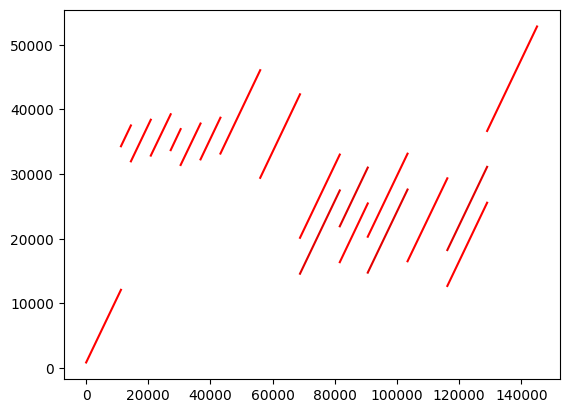

In [5]:
with open("reference.txt",'r') as file:
    reference=file.read()
with open("sample.txt",'r') as file:
    sample=file.read()

topk=9

match_list=DNA_match(reference,sample,50,30,topk)
for i in range(len(match_list)):match_list[i]=match_list[i][0]
printPhaseMatch(match_list,topk)

In [6]:
origin=[[],[]]
for i in match_list:
    origin[0].append([i.l,i.r])
    origin[1].append([i.scorelist[0][1],i.scorelist[0][2]])

def trans(data):
    l=[]
    for i in range(len(data[0])):
        l.append((data[0][i][0],data[0][i][1],data[1][i][0],data[1][i][1]))
    return l
print(origin)
print(trans(origin))
print(calculate_value(trans(origin),reference,sample,30))


[[[0, 11200], [11200, 14400], [14400, 20800], [20800, 27200], [27200, 30400], [30400, 36800], [36800, 43200], [43200, 56000], [56000, 68800], [68800, 81600], [81600, 90600], [90600, 103400], [103400, 116200], [116200, 129000], [129000, 145063]], [[871, 12103], [34296, 37513], [31964, 38398], [32851, 39244], [33697, 36950], [31401, 37812], [32266, 38713], [33166, 46056], [29416, 42328], [20146, 33012], [16376, 25455], [20312, 33151], [16516, 29341], [12699, 25567], [36660, 52814]]]
[(0, 11200, 871, 12103), (11200, 14400, 34296, 37513), (14400, 20800, 31964, 38398), (20800, 27200, 32851, 39244), (27200, 30400, 33697, 36950), (30400, 36800, 31401, 37812), (36800, 43200, 32266, 38713), (43200, 56000, 33166, 46056), (56000, 68800, 29416, 42328), (68800, 81600, 20146, 33012), (81600, 90600, 16376, 25455), (90600, 103400, 20312, 33151), (103400, 116200, 16516, 29341), (116200, 129000, 12699, 25567), (129000, 145063, 36660, 52814)]
139316


In [ ]:
import numpy as np
def trans(data):
    l=[]
    for i in range(len(data[0])):
        l.append((data[0][i][0],data[0][i][1],data[1][i][0],data[1][i][1]))
    return l

def scoring(data):
    return calculate_value(trans(data),reference,sample,30)

for round in range(100):
    l=round%(len(origin[0])-1)
    origin1=[
        [origin[0][l][0],origin[0][l][1],origin[0][l+1][1]],
        [[origin[1][l][0],origin[1][l][1]],[origin[1][l+1][0],origin[1][l+1][1]]]
    ]
    saml=0 if l==0 else origin[0][l-1][1]
    samr=len(sample) if l+1==len(origin[0])-1 else origin[0][l+2][0]

    def update1(data,t0):
        newdata=copy.deepcopy(data)
        dv=max(int(t0),1)
        for i in range(len(data[0])):
            newdata[0][i]=np.clip(data[0][i]+np.random.randint(-dv,dv),saml,samr)
        newdata[0].sort()

        for i in range(len(data[1])):
            def update1(data,t0):
                dv=max(int(t0),10)
                newdata:list=copy.deepcopy(data)
                newdata[0]=newdata[0]+np.random.randint(-dv,dv)
                newdata[0]=np.clip(newdata[0],0,len(reference))
                newdata[1]=newdata[1]+np.random.randint(-dv,dv)
                newdata[1]=np.clip(newdata[1],0,len(reference))
                newdata.sort()
                return newdata
            def scoring1(data1):
                return calculate_value([(newdata[0][i],newdata[0][i+1],data1[0],data1[1])],reference,sample,30)
            
            newdata[1][i],score=simulated_annealing(data[1][i],update1,scoring1,t0,0.96,10)
        return newdata
    
    def trans1(data):
        l=[]
        for i in range(len(data[1])):
            l.append((data[0][i],data[0][i+1],data[1][i][0],data[1][i][1]))
        return l

    def scoring1(data):
        return calculate_value(trans1(data),reference,sample,30)
    
    data1,score=simulated_annealing(origin1,update1,scoring1,200,0.96,10)
    origin[0][l],origin[0][l+1]=(data1[0][0],data1[0][1]),(data1[0][1],data1[0][2])
    origin[1][l],origin[1][l+1]=data1[1][0],data1[1][1]
    print(round,scoring(origin),trans(origin),sep=" ")


print(trans(origin))
print(scoring(origin))    

0 139320 [(0, 11294, 870, 12198), (11294, 14400, 34391, 37513), (14400, 20800, 31964, 38398), (20800, 27200, 32851, 39244), (27200, 30400, 33697, 36950), (30400, 36800, 31401, 37812), (36800, 43200, 32266, 38713), (43200, 56000, 33166, 46056), (56000, 68800, 29416, 42328), (68800, 81600, 20146, 33012), (81600, 90600, 16376, 25455), (90600, 103400, 20312, 33151), (103400, 116200, 16516, 29341), (116200, 129000, 12699, 25567), (129000, 145063, 36660, 52814)]
1 139327 [(0, 11294, 870, 12198), (11294, 14767, 34391, 37884), (14767, 20800, 32342, 38398), (20800, 27200, 32851, 39244), (27200, 30400, 33697, 36950), (30400, 36800, 31401, 37812), (36800, 43200, 32266, 38713), (43200, 56000, 33166, 46056), (56000, 68800, 29416, 42328), (68800, 81600, 20146, 33012), (81600, 90600, 16376, 25455), (90600, 103400, 20312, 33151), (103400, 116200, 16516, 29341), (116200, 129000, 12699, 25567), (129000, 145063, 36660, 52814)]
2 139331 [(0, 11294, 870, 12198), (11294, 14767, 34391, 37884), (14767, 20634,